# Dropout mlp

In [1]:
from __future__ import print_function
import numpy as np
from IPython.display import clear_output
np.random.seed(42)

In [2]:
def sgd(w, dw, config=None):
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw
    return w, config


def sgd_momentum(w, dw, config=None):
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('momentum', 0.9)
    v = config.get('velocity', np.zeros_like(w))

    next_w = None
    mu = config.get('momentum')
    learning_rate = config.get('learning_rate')

    v = mu*v - learning_rate*dw
    w += v

    next_w = w
    config['velocity'] = v

    return next_w, config

def adam(x, dx, config=None):
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(x))
    config.setdefault('v', np.zeros_like(x))
    config.setdefault('t', 1)

    next_x = None
    m = config.get('m')
    v = config.get('v')
    beta1 = config.get('beta1')
    beta2 = config.get('beta2')
    t = config.get('t') + 1
    learning_rate = config.get('learning_rate')
    epsilon = config.get('epsilon')

    new_m = beta1*m + (1-beta1)*dx
    mt = new_m / (1-beta1**t)
    new_v = beta2*v + (1-beta2)*(dx**2)
    vt = new_v / (1-beta2**t)
    x += -learning_rate * mt / (np.sqrt(vt) + epsilon)
    next_x = x
    config['m'] = new_m
    config['v'] = new_v
    config['t'] = t
    return next_x, config

In [3]:
class Layer:
    """
    定义单层抽象Layer，分别为前向传播和反向传播
    output = layer.forward(input)
    grad_input = layer.backward(input, grad_output)
    """
    def __init__ (self):
        pass
    
    def forward(self, input,mode):
        """
        batch,input_units]
        return [batch,output_units]
        """
        return input

    def backward(self,input, grad_output):
        """
        需要重写其方法
        """
        pass

In [4]:
class ReLU(Layer):
    def __init__(self):
        pass
    def forward(self,input,mode):
        return np.maximum(0,input)
    
    def backward(self,input,grad_output):        
        relu_grad = input>0
        return grad_output*relu_grad

In [13]:
class Dense(Layer):
    def __init__(self,input_units,output_units,learning_rate=0.1,initialization='xavier'):
        """
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        """
        xavier初始化 np.sqrt(2/(m+n))
        """
        if initialization == 'xavier':
            self.weights = np.random.randn(input_units, output_units) * np.sqrt(2.0/(input_units+output_units))
        else:
            self.weights = np.random.randn(input_units, output_units) * 0.01
        self.biases = np.zeros(output_units)
        
        
        self.config = None
        
    def forward(self,input,mode):
        """
        f(x) = <W*x> + b
        
        [batch, input_units]
        [batch, output units]
        """
        return np.dot(input,self.weights) + self.biases 
    
    def backward(self,input,grad_output):
        
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(input.T,grad_output)/input.shape[0]
        
        self.weights,self.config = adam(self.weights,grad_weights,self.config)
            
        
        grad_biases = grad_output.mean(axis=0)
        self.biases = self.biases - self.learning_rate*grad_biases
        
        return grad_input

In [14]:
class Dropout(Layer):
    def __init__(self,p):
        self.p = p
    def forward(self,input,mode):
        self.mode = mode
        if self.mode=='test':
            return input
        self.mask = (np.random.rand(*input.shape)>=self.p)/(1-self.p)
        input = input * self.mask
        return input
    def backward(self,input,grad_output):
        return grad_output*self.mask

In [15]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return - ones_for_answers + softmax

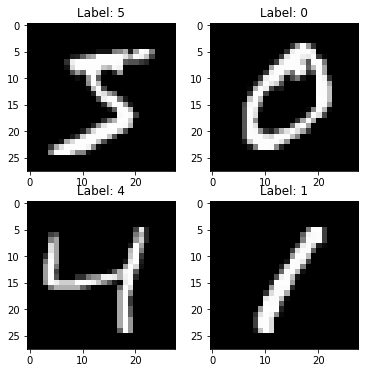

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [17]:
def forward(network,X,mode):
    activations = []
    input = X
    for layer in network:
        activations.append(layer.forward(input,mode))
        input = activations[-1]
        
        
    assert len(activations) == len(network)
    return activations

def predict(network,X,mode='train'):
    logits = forward(network,X,mode)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    layer_activations = forward(network,X,mode='train')
    layer_inputs = [X]+layer_activations
    logits = layer_activations[-1]
    
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    for layer_i in range(len(network))[::-1]:
        layer = network[layer_i]
        
        loss_grad = layer.backward(layer_inputs[layer_i],loss_grad)
        
    return np.mean(loss)

In [18]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [19]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dropout(0.2))
network.append(Dense(100,100))
network.append(ReLU())
network.append(Dropout(0.5))
network.append(Dense(100,10))

Epoch 36
Train accuracy: 0.98576
Val accuracy: 0.9793


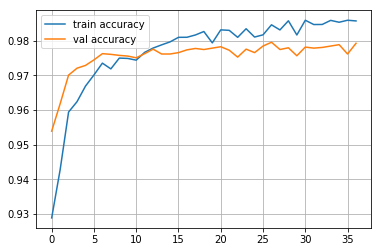

 16%|█▌        | 249/1562 [00:00<00:03, 345.22it/s]


KeyboardInterrupt: 

In [20]:
train_log = []
val_log = []
for epoch in range(100):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        loss = train(network,x_batch,y_batch)
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val,mode='test')==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [21]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,100))
network.append(ReLU())
network.append(Dense(100,10))

Epoch 24
Train accuracy: 0.99852
Val accuracy: 0.9781


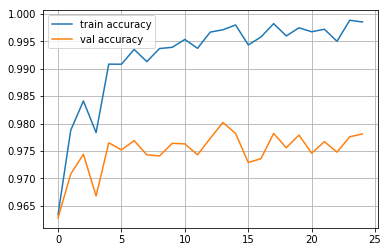

In [22]:
train_log = []
val_log = []
for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val,mode='test')==y_val))
   
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()